# 01 - NMF experiments on Zeisel

* nimfa installed with `pip`
* https://stackoverflow.com/questions/46516022/reconstruction-error-on-test-set-for-nmf-aka-nnmf-in-scikit-learn
    * use the `beta_divergence` function

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from numpy import ma
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE
from umap import UMAP

import nimfa as ni

In [3]:
tab10_dict = dict(enumerate(plt.cm.get_cmap('tab10').colors))

In [4]:
zeisel_path = '/media/tmo/data/work/datasets/zeisel/expression_sara_filtered.txt'
zeisel_meta_path = '/media/tmo/data/work/datasets/zeisel/expression_mRNA_17-Aug-2014.txt'

In [5]:
%%time
zeisel_df = pd.read_csv(zeisel_path, sep='\t', skiprows=1, header=None, index_col=0)
zeisel_df.index.name = 'gene'

CPU times: user 4.95 s, sys: 464 ms, total: 5.42 s
Wall time: 5.42 s


In [6]:
zeisel_meta_df = pd.read_table(zeisel_meta_path, nrows=12, index_col=1, header=None)
zeisel_meta_df.drop(zeisel_meta_df.columns[0], axis=1, inplace=True)
zeisel_meta_df = zeisel_meta_df.T.reset_index()[['tissue', 'level1class', 'level2class']]
zeisel_meta_df.index.name = 'cell'

In [7]:
for meta_col in zeisel_meta_df.columns:
    zeisel_meta_df[meta_col] = zeisel_meta_df[meta_col].astype('category')

In [8]:
zeisel_meta_df.head()

1,tissue,level1class,level2class
cell,,,
0,sscortex,interneurons,Int10
1,sscortex,interneurons,Int10
2,sscortex,interneurons,Int6
3,sscortex,interneurons,Int10
4,sscortex,interneurons,Int9


In [9]:
genes = zeisel_df.index

In [12]:
zeisel_m = zeisel_df.values

In [13]:
zeisel_m.shape

(13063, 3005)

# Model fitting

In [14]:
def fit_nmf(X, model = NMF(n_components=20,                            
                           init='nndsvd', 
                           random_state=42, 
                           verbose=False)):
    fit_model = deepcopy(model)
    
    W = fit_model.fit_transform(X) # basis matrix
    H = fit_model.components_      # mixture matrix
       
    return fit_model, W, H

In [15]:
def tsne_embed(X):
    return pd.DataFrame(TSNE().fit_transform(X))

# Prep

In [16]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler(with_mean=False, with_std=True)

In [22]:
scaled = scaler.fit_transform(zeisel_m.T).T

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
scaled

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.16599268],
       [ 2.46756035,  0.82252012,  0.        , ...,  0.        ,
         0.        ,  0.82252012],
       [ 1.5046726 ,  0.50155753,  3.0093452 , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  8.65102986, ...,  0.        ,
         0.        ,  0.        ]])

In [24]:
scaled.shape

(13063, 3005)

# PCA

In [32]:
pca = PCA(n_components=12)
pca

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [33]:
%%time
pca.fit(scaled.T)

CPU times: user 14 s, sys: 30.6 s, total: 44.6 s
Wall time: 4.07 s


PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

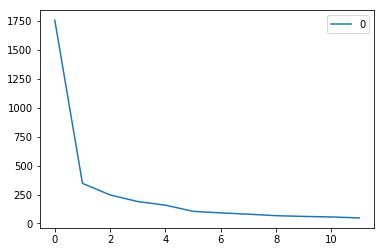

In [34]:
pd.DataFrame(pca.explained_variance_).plot()
plt.show()

266.97111073997286

In [35]:
X_pca = pca.transform(scaled.T)

In [36]:
X_pca.shape

(3005, 12)

In [37]:
%%time
pca_12_tsne_df = tsne_embed(X_pca)

CPU times: user 59.1 s, sys: 15 s, total: 1min 14s
Wall time: 1min 14s


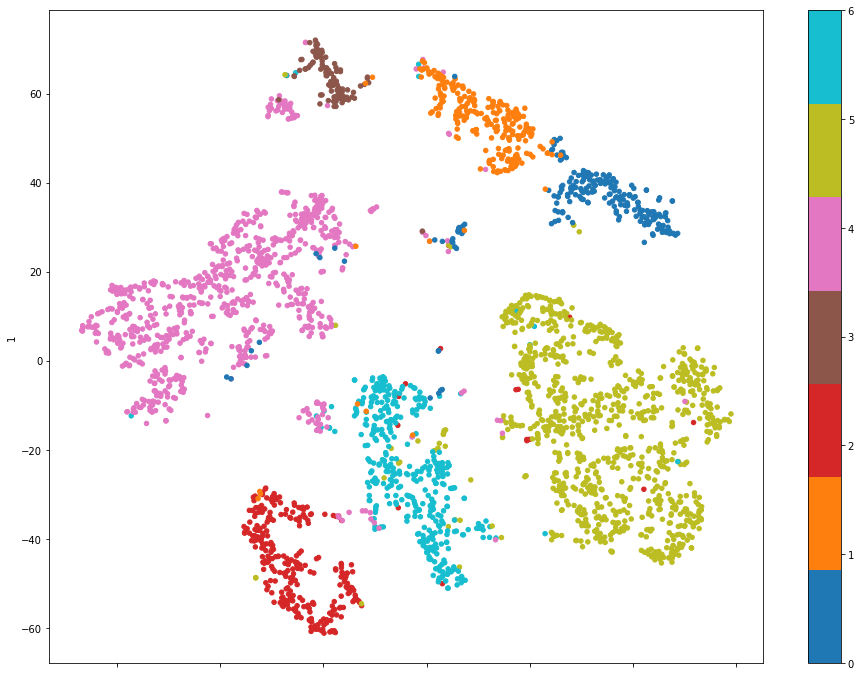

In [38]:
pca_12_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10', 7), figsize=(16,12))
plt.show()

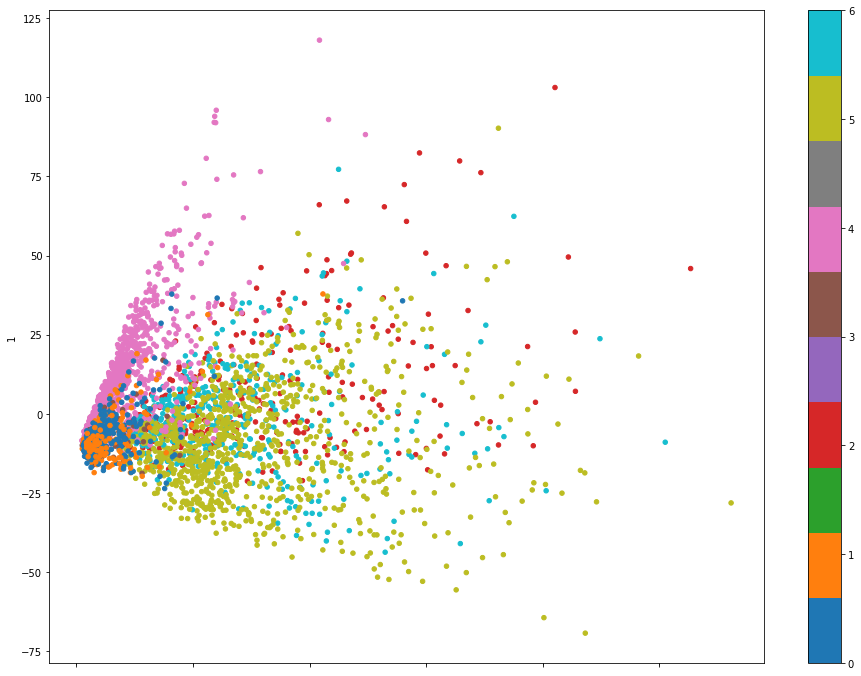

In [39]:
pd.DataFrame(X_pca[:, [0, 1]]).plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

* probably what we see here is a (rotated) depiction of the **positive cone** of the RNA-seq data points.

# NMF on scaled

* reconstruction error smaller --> reason?
* apparently better results in the t-SNE

In [25]:
model_scaled_20, W_scaled_20, H_scaled_20 = fit_nmf(scaled)

In [26]:
model_scaled_20.reconstruction_err_

5382.9081032526301

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


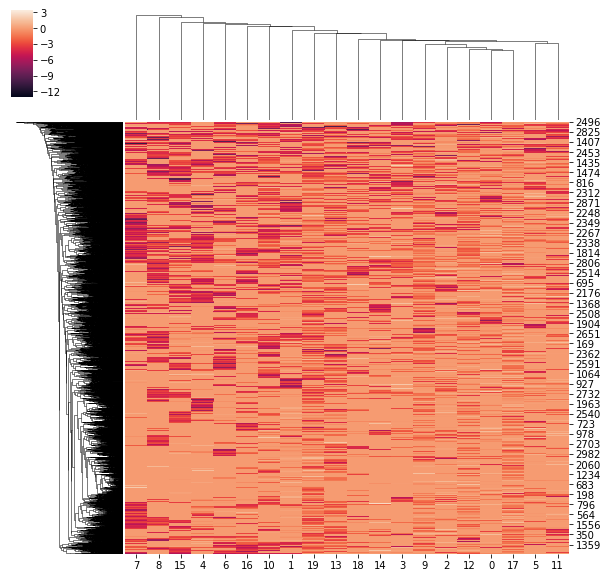

In [27]:
sns.clustermap(ma.filled(np.log(ma.masked_equal(H_scaled_20, 0)).T, 0))
plt.show()

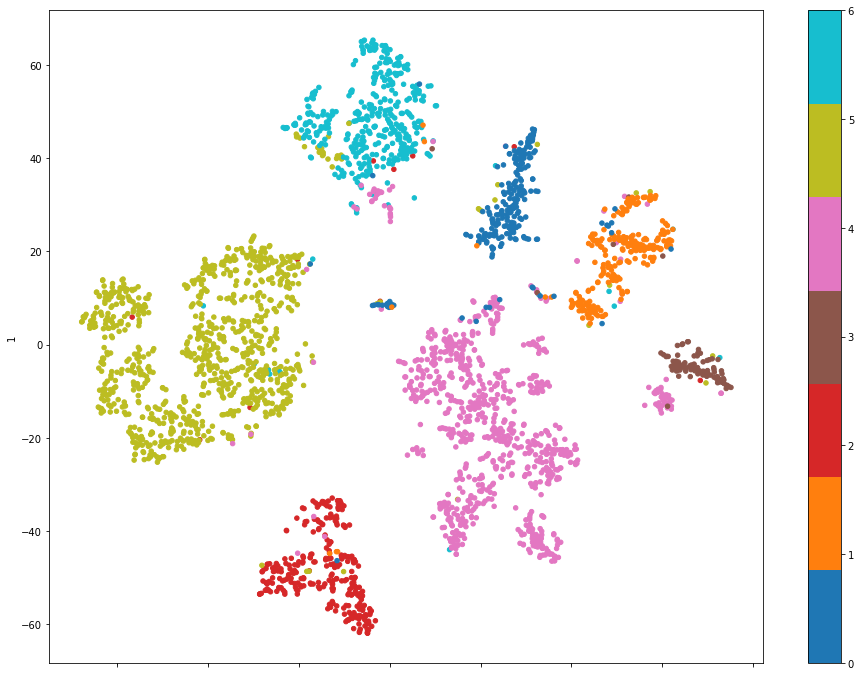

CPU times: user 1min 2s, sys: 15.4 s, total: 1min 17s
Wall time: 1min 17s


In [30]:
%%time
scaled_20_tsne_df = tsne_embed(H_scaled_20.T)
scaled_20_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10', 7), figsize=(16,12))
plt.show()

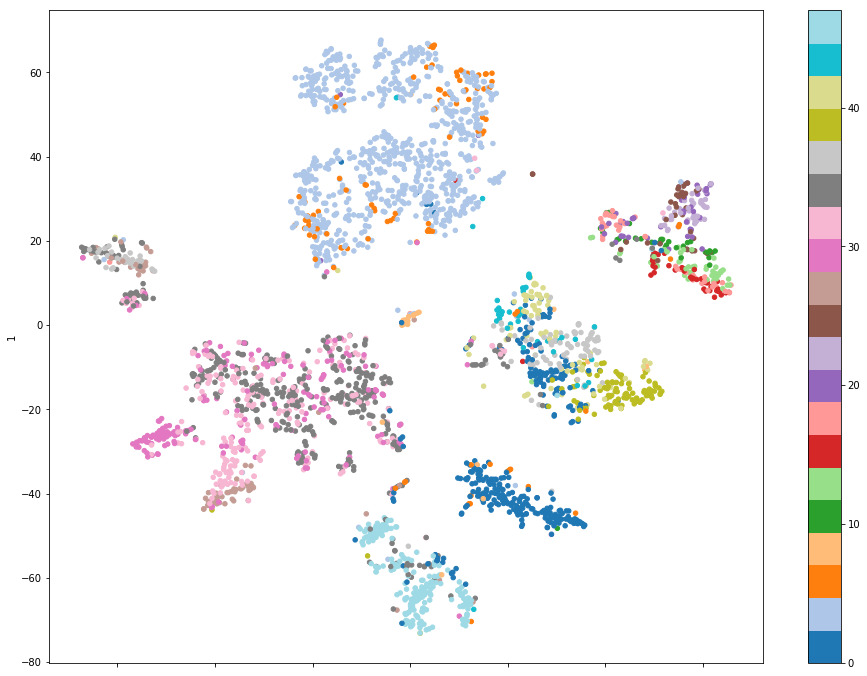

In [29]:
scaled_20_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level2class'].cat.codes, cmap=plt.cm.get_cmap('tab20'), figsize=(16,12))
plt.show()

# 20 components

In [125]:
%%time
model, W, H = fit_nmf(zeisel_m)

CPU times: user 1min 30s, sys: 44.6 s, total: 2min 15s
Wall time: 1min 15s


In [126]:
model.reconstruction_err_

11380.607178310001

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


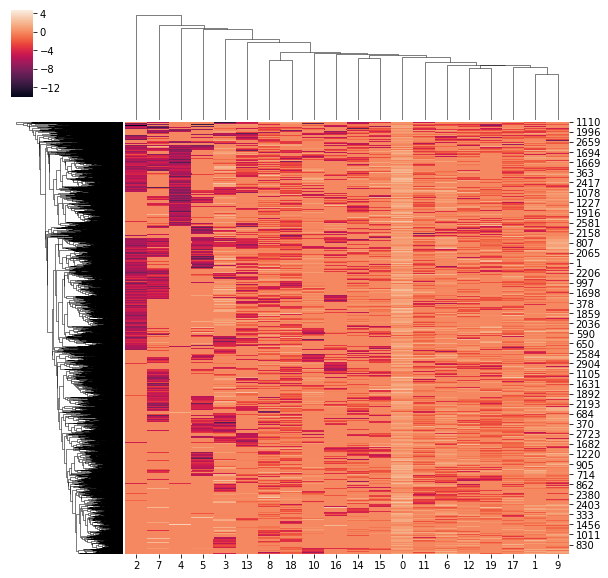

In [136]:
sns.clustermap(ma.filled(np.log(ma.masked_equal(H, 0)).T, 0))
plt.show()

In [134]:
%%time
tsne_df = pd.DataFrame(TSNE(random_state=666).fit_transform(H.T))

CPU times: user 1min 3s, sys: 15.3 s, total: 1min 18s
Wall time: 1min 18s


In [35]:
%%time
umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(H.T))

NameError: name 'H' is not defined

In [31]:
tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10', 7), figsize=(16,12))
plt.show()

NameError: name 'tsne_df' is not defined

In [109]:
%%time
model2 = NMF(n_components=20,
             alpha=10,
             init='nndsvd', 
             random_state=42, 
             verbose=False)

model2, W2, H2 = fit_nmf(scaled, model2)

CPU times: user 1min 31s, sys: 44.9 s, total: 2min 16s
Wall time: 1min 16s


In [110]:
model2.reconstruction_err_

5386.6149150744441

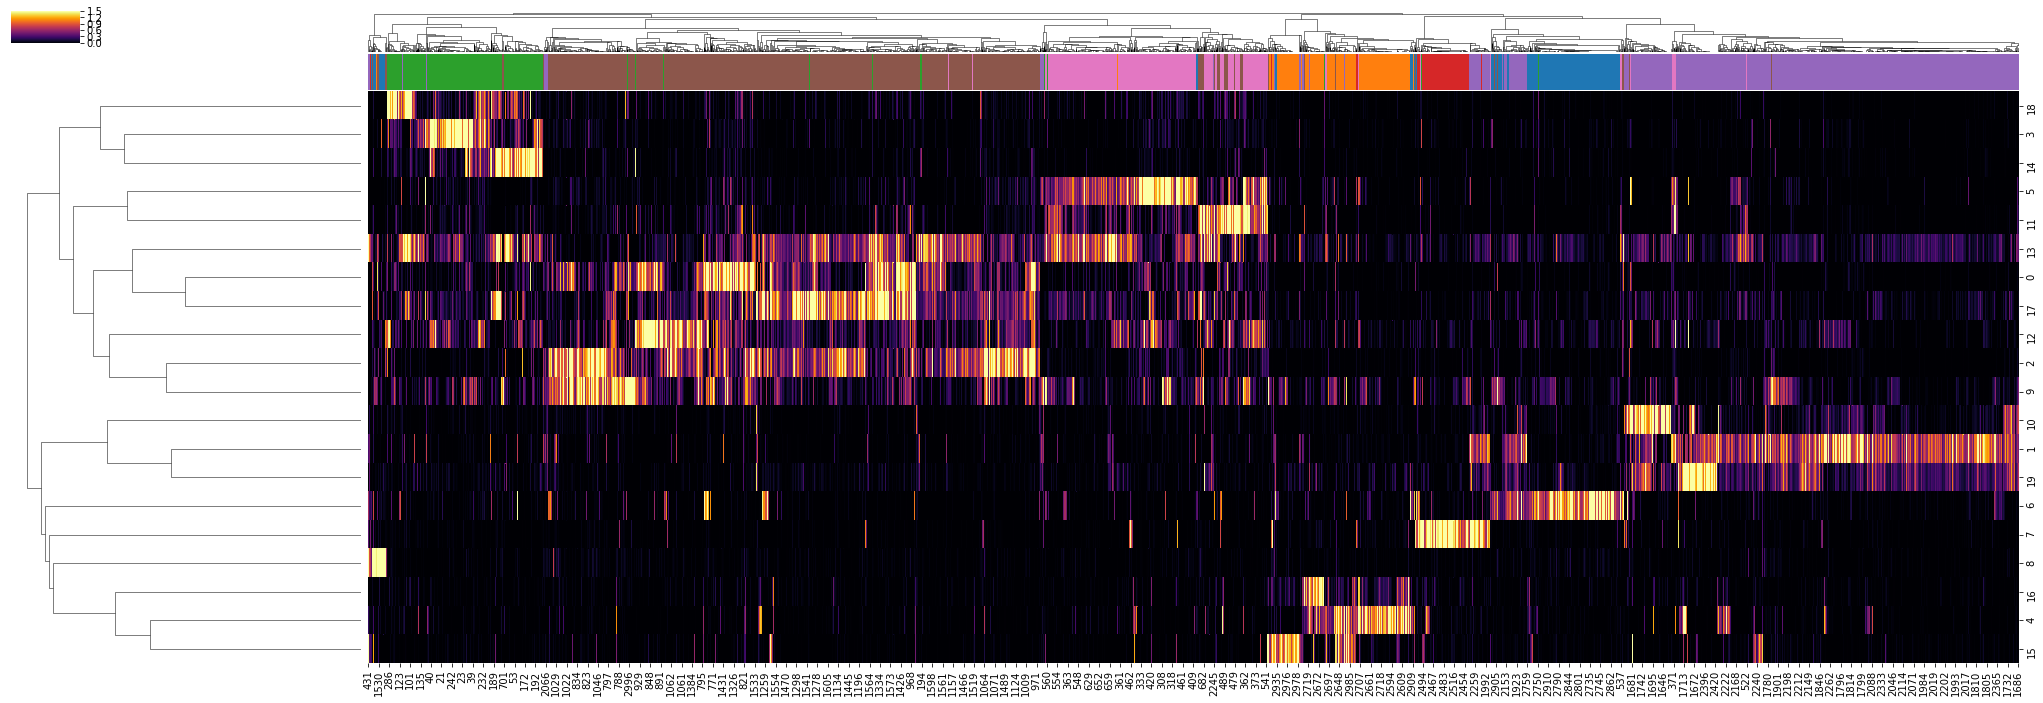

In [113]:
colors_by_level1class = list(map(lambda x: tab10_dict[x], zeisel_meta_df['level1class'].cat.codes))

sns.clustermap(H2,
               cmap='inferno',
               col_colors=colors_by_level1class,
               metric='correlation',
               robust=True,
               figsize=(36, 12))
plt.show()

In [122]:
%%time
umap_df_l2 = pd.DataFrame(UMAP(random_state=666).fit_transform(H2.T))

CPU times: user 15 s, sys: 10.5 s, total: 25.5 s
Wall time: 12.4 s


In [ ]:
umap_df_l2.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10', 7), figsize=(16,12))
plt.show()

In [124]:
%%time
tsne_df_2 = pd.DataFrame(TSNE(random_state=666).fit_transform(H2.T))

CPU times: user 1min 1s, sys: 38.5 s, total: 1min 39s
Wall time: 1min 39s


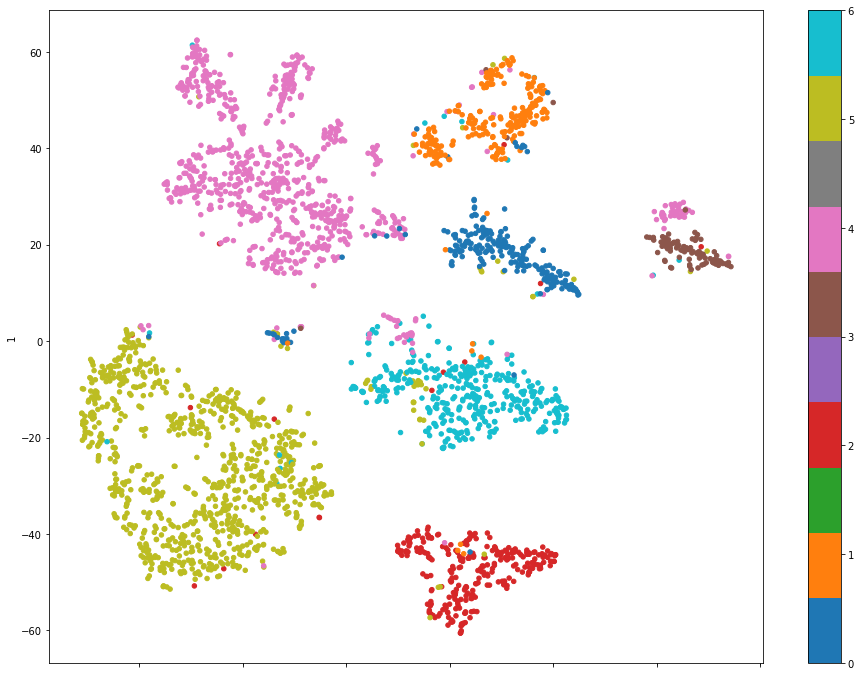

In [125]:
tsne_df_2.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

---

# Nimfa sparse NMF

In [136]:
snmf = ni.Snmf(scaled, seed="nndsvd", rank=30, max_iter=20)

In [137]:
%%time

fit = snmf()
fig, ax = plt.subplots(1,1, figsize=(16, 12))
(fit.basis(), fit.coef())

CPU times: user 15min 20s, sys: 11min 58s, total: 27min 19s
Wall time: 10min 3s


In [138]:
fit.fit.sparseness()

(0.44608130960565795, 0.80103827338897537)

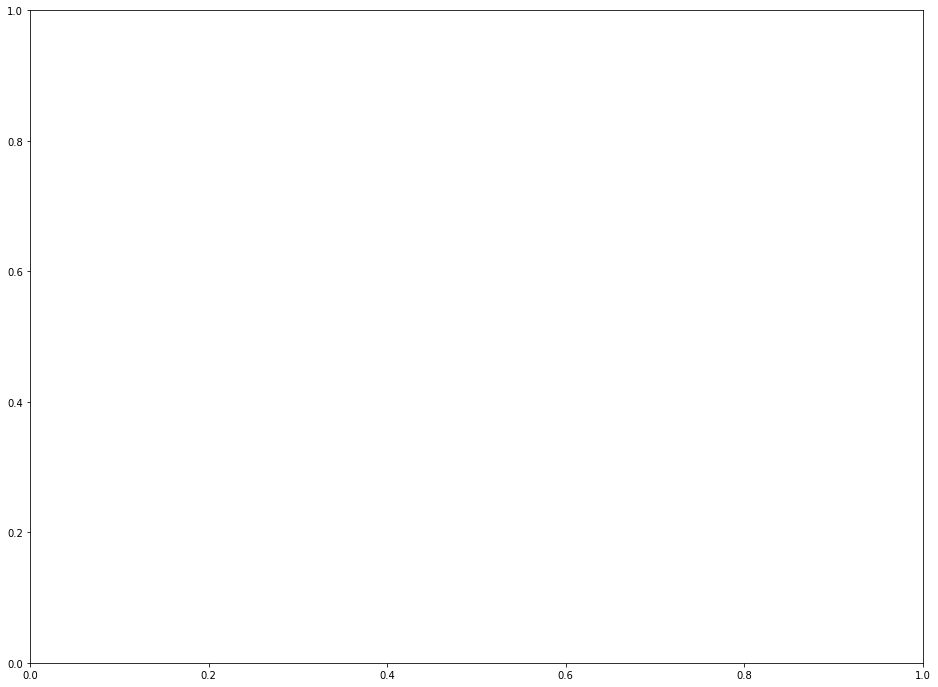

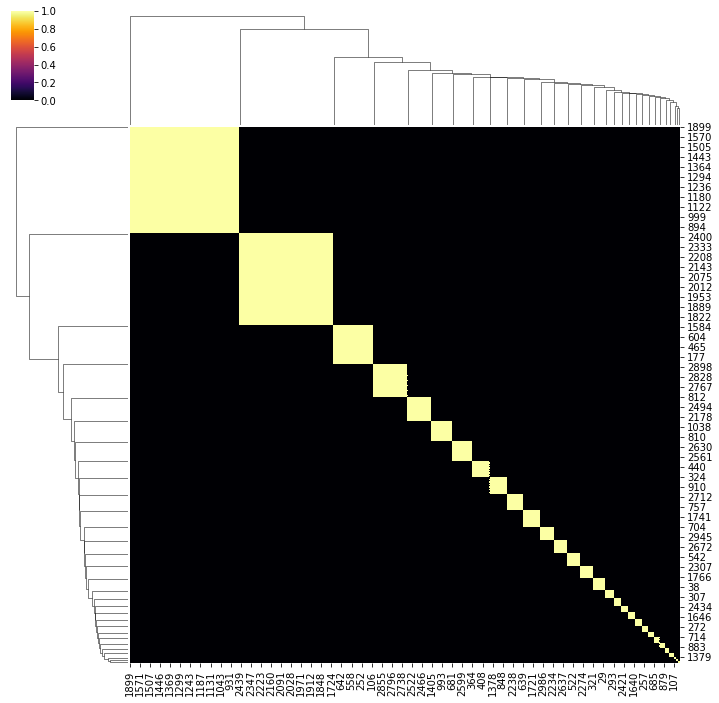

In [139]:
cnxn = fit.fit.connectivity()

sns.clustermap(cnxn, metric='euclidean', cmap='inferno', figsize=(12, 12))

plt.show()

In [140]:
sparse_w = fit.basis()
sparse_h = fit.coef()

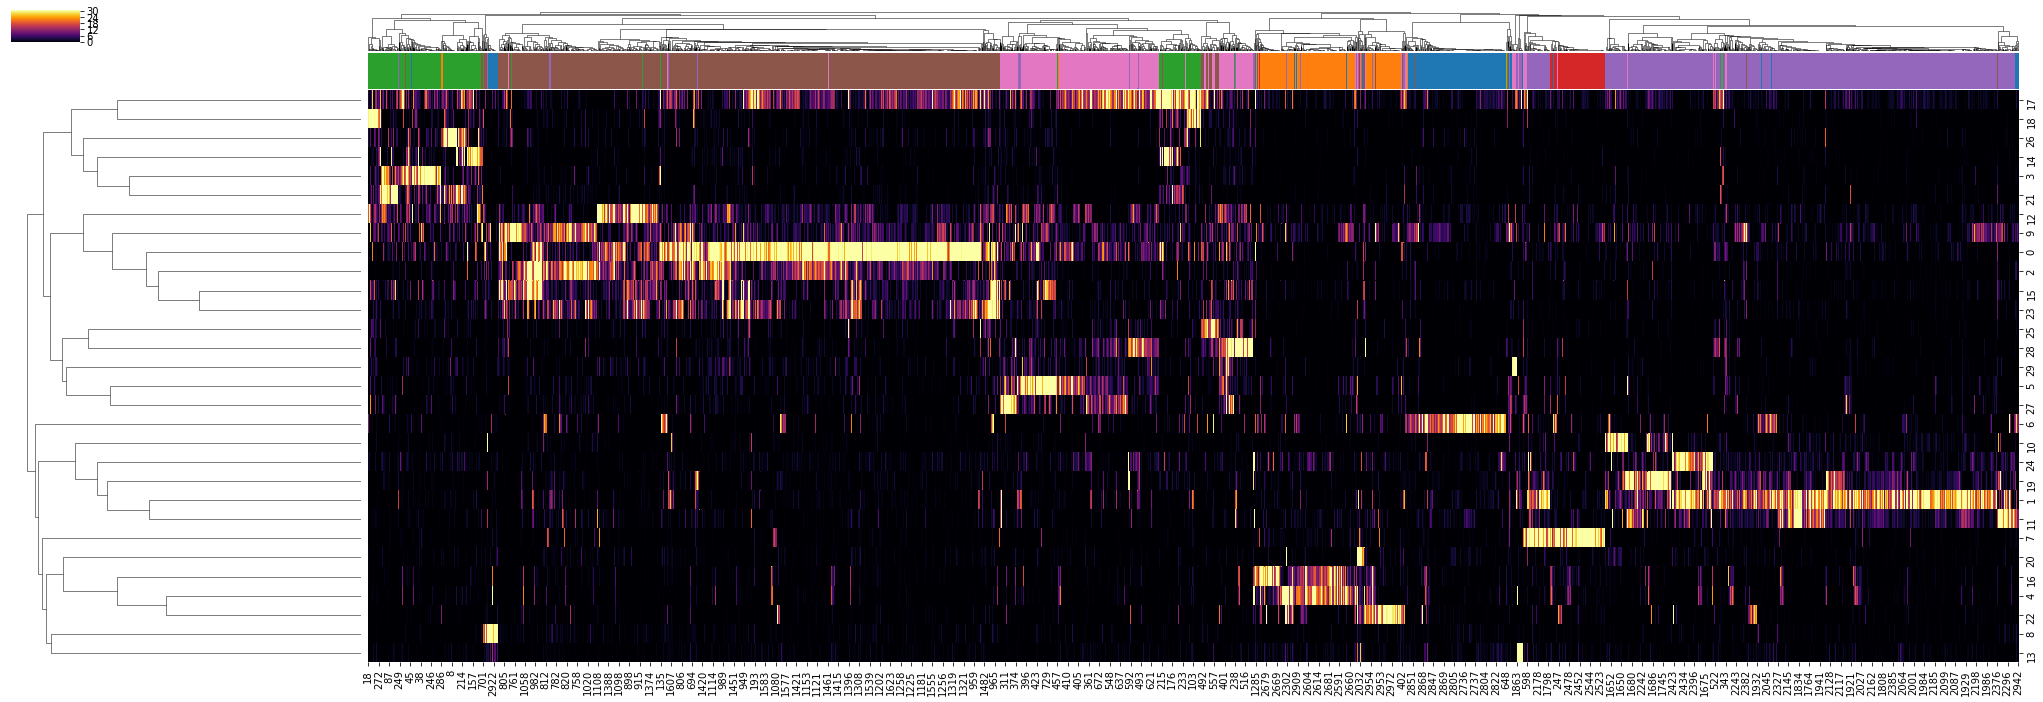

In [141]:
sns.clustermap(sparse_h, 
               cmap='inferno',           
               col_colors=colors_by_level1class,
               robust=True, 
               metric='correlation',
               figsize=(36, 12))
plt.show()

In [142]:
nimfa_umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(sparse_h.T))

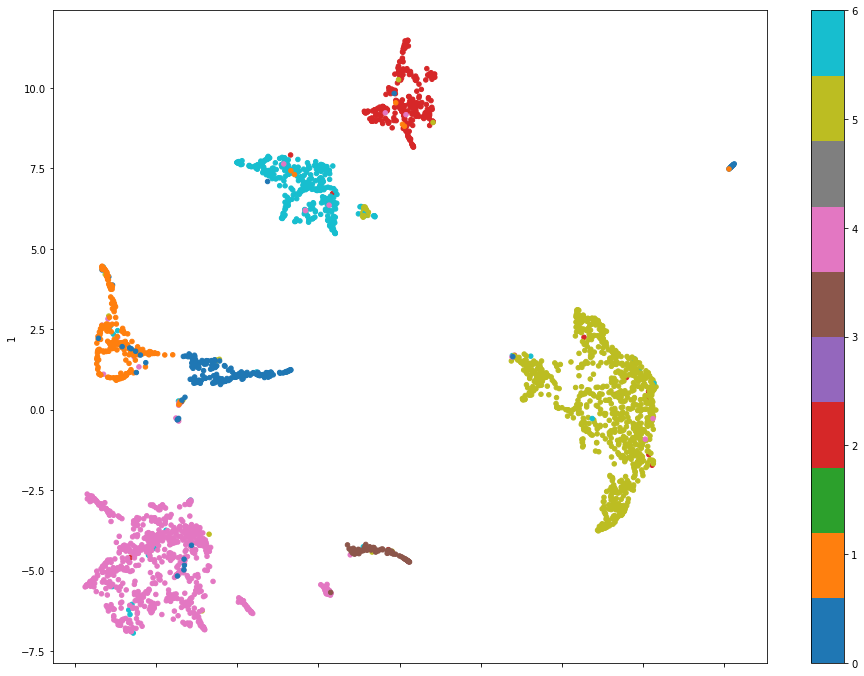

In [143]:
nimfa_umap_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

---

# Nimfa separable NMF

In [77]:
sepnmf = ni.SepNmf(zeisel_m)

In [78]:
%%time
sep_fit = sepnmf()

CPU times: user 32min 43s, sys: 8min 34s, total: 41min 17s
Wall time: 3min 48s


In [79]:
sep_W = sep_fit.basis()

In [80]:
sep_H = sep_fit.coef()

In [81]:
(sep_W.shape, sep_H.shape)

((13063, 30), (30, 3005))

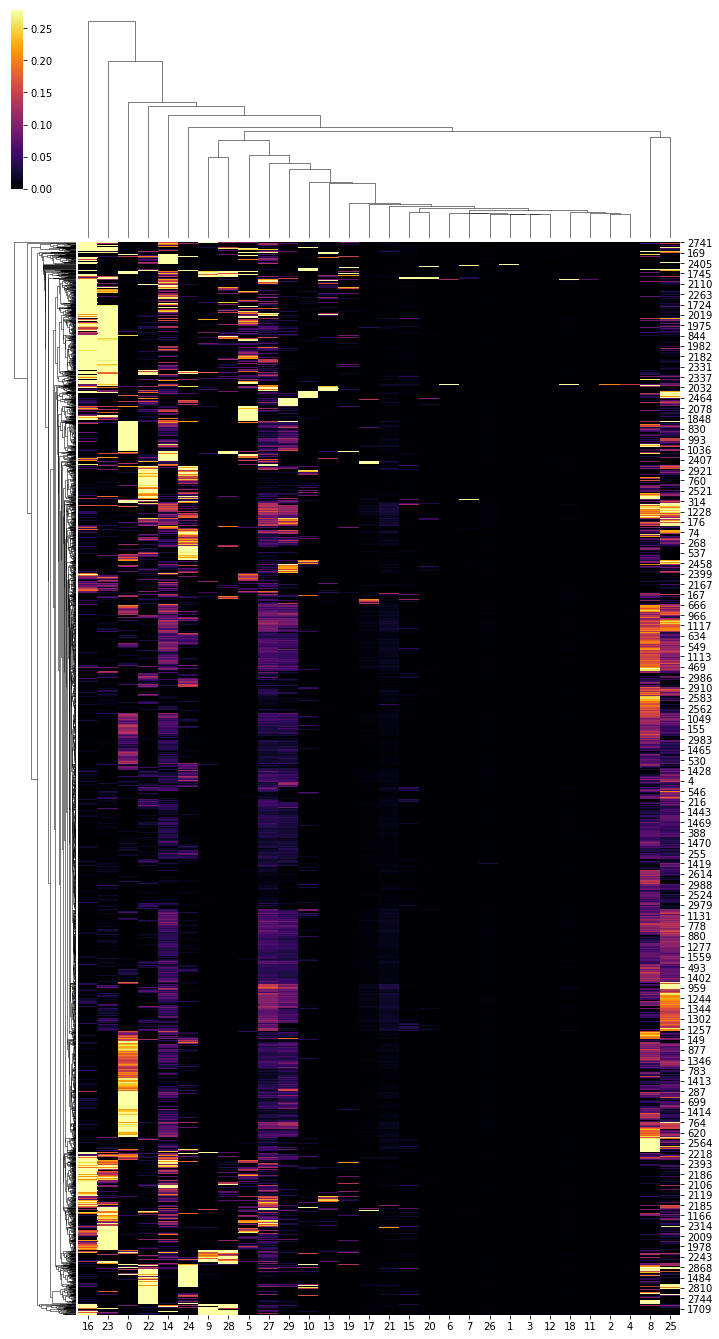

In [82]:
sns.clustermap(sep_H.T,
               cmap='inferno',               
               robust=True, 
               figsize=(12, 24))
plt.show()

In [83]:
%%time
sep_tsne_df = tsne_embed(sep_H.T)

CPU times: user 1min 2s, sys: 14.8 s, total: 1min 16s
Wall time: 1min 16s


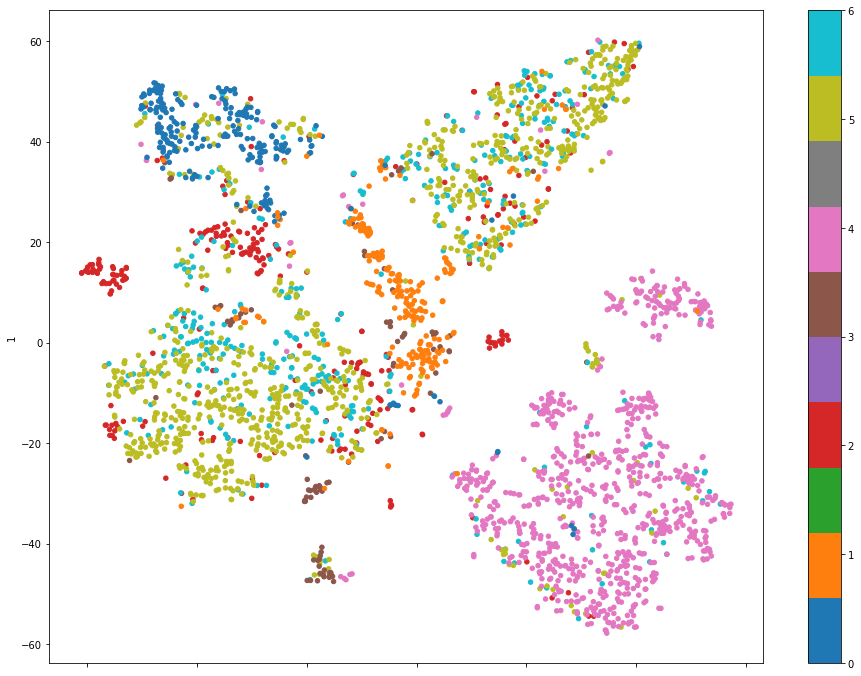

In [84]:
sep_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

In [85]:
sep_umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(sep_H.T))

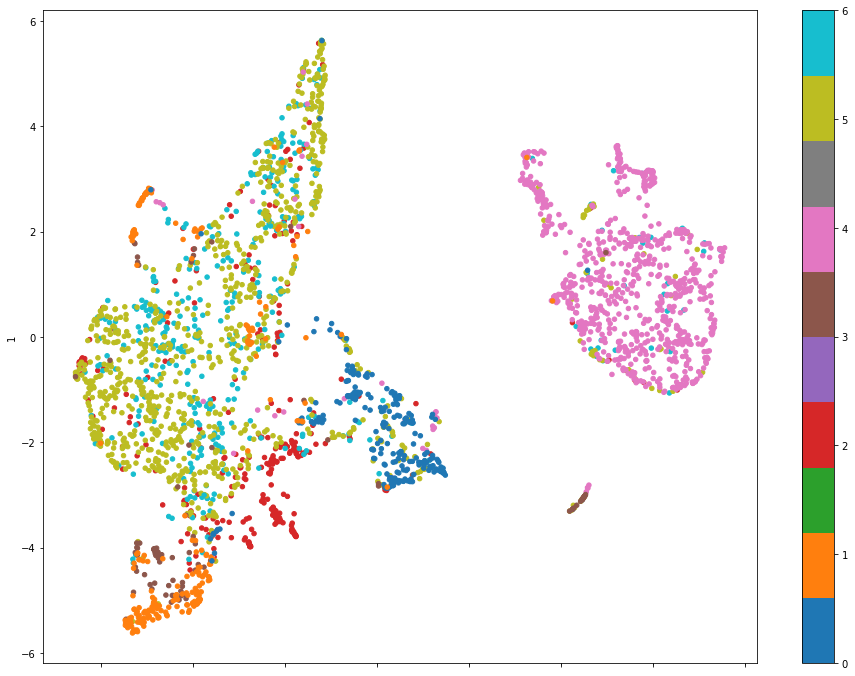

In [86]:
sep_umap_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

In [27]:
%%time
model3 = NMF(n_components=20,
             solver='mu',
             init='nndsvda', 
             random_state=42, 
             verbose=False)

model3, W3, H3 = fit_nmf(zeisel_m, model3)

CPU times: user 1min 33s, sys: 1min 23s, total: 2min 56s
Wall time: 1min 1s


In [28]:
model3.reconstruction_err_

11435.959470033404

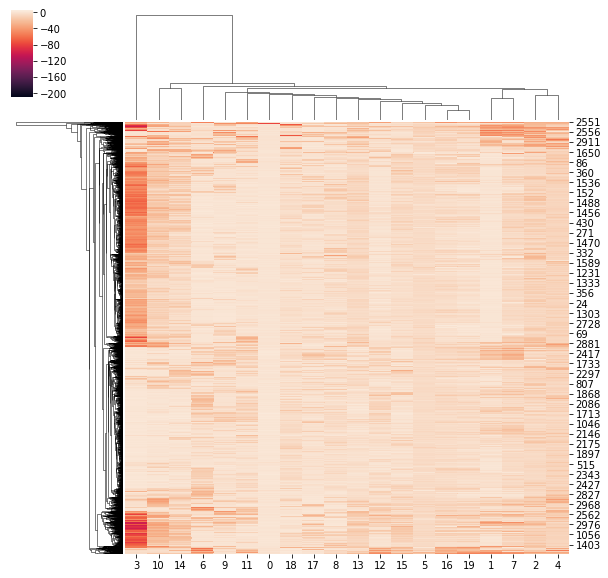

In [29]:
sns.clustermap(ma.filled(np.log(ma.masked_equal(H3, 0)).T, 0))
plt.show()

In [ ]:
%%time
tsne_df_3 = pd.DataFrame(TSNE(random_state=666, metric='manhattan').fit_transform(H3.T))

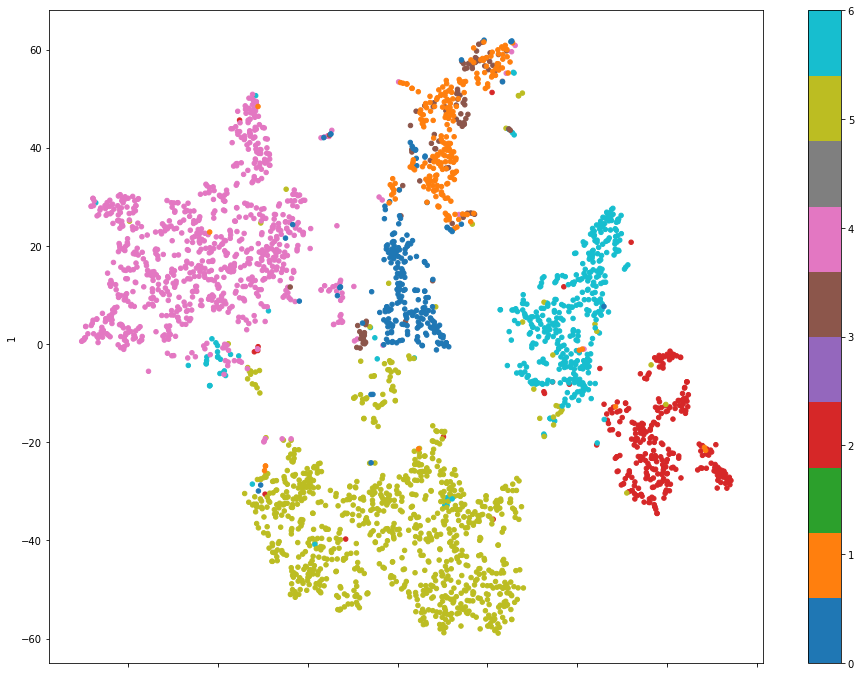

In [33]:
tsne_df_3.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()